In [1]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import pandas as pd

# Load the usual suspects:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import pandas as pd

# Fiddle with figure settings here:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

# A simple little 2D matrix plotter, excluding x and y labels.
def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

In [2]:
store_sales = pd.read_csv("data/store4_salses.csv")
store_sales.head()

,date,sales
0,2017-01-01,0.00000
1,2017-01-02,708.67680
2,2017-01-03,547.86127
3,2017-01-04,527.43600
4,2017-01-05,402.13992


In [3]:
sales = store_sales['sales'].copy()
sales = sales.to_numpy()
F = sales

In [4]:
import numpy as np
# Fed_SSA/results/SSA/Grassmann_ADMM_StoreSale_3_L20_d20.npy
U_k = np.load('results/SSA/Grassmann_ADMM_StoreSale_3_L20_d20.npy')
U_k.shape

(20, 20)

In [5]:
N = sales.shape[0]
L = 20 # The window length
K = N - L + 1  # number of columns in the trajectory matrix

X = np.column_stack([F[i:i+L] for i in range(0,K)])
d= L
t = np.arange(0,N)

In [6]:
X_elem_pca = np.array([np.dot(np.dot(np.expand_dims(U_k[:,i], axis=1), np.expand_dims(U_k[:,i].T, axis=0)), X) for i in range(0,d)])

In [7]:
def Hankelise(X):
    """
    Hankelises the matrix X, returning H(X).
    """
    L, K = X.shape
    transpose = False
    if L > K:
        # The Hankelisation below only works for matrices where L < K.
        # To Hankelise a L > K matrix, first swap L and K and tranpose X.
        # Set flag for HX to be transposed before returning. 
        X = X.T
        L, K = K, L
        transpose = True

    HX = np.zeros((L,K))
    
    # I know this isn't very efficient...
    for m in range(L):
        for n in range(K):
            s = m+n
            if 0 <= s <= L-1:
                for l in range(0,s+1):
                    HX[m,n] += 1/(s+1)*X[l, s-l]    
            elif L <= s <= K-1:
                for l in range(0,L-1):
                    HX[m,n] += 1/(L-1)*X[l, s-l]
            elif K <= s <= K+L-2:
                for l in range(s-K+1,L):
                    HX[m,n] += 1/(K+L-s-1)*X[l, s-l]
    if transpose:
        return HX.T
    else:
        return HX

In [8]:
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

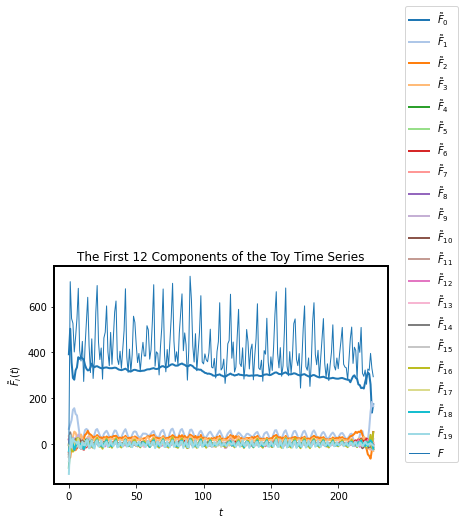

In [9]:
n = min(70,d) # In case of noiseless time series with d < 12.

# Fiddle with colour cycle - need more colours!
fig = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
fig.axes.set_prop_cycle(color_cycle)

# Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
for i in range(n):
    F_i = X_to_TS(X_elem_pca[i])
    fig.axes.plot(t, F_i, lw=2)

fig.axes.plot(t, F, alpha=1, lw=1)
fig.set_xlabel("$t$")
fig.set_ylabel(r"$\tilde{F}_i(t)$")
legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
fig.set_title("The First 12 Components of the Toy Time Series")
fig.legend(legend, loc=(1.05,0.1));

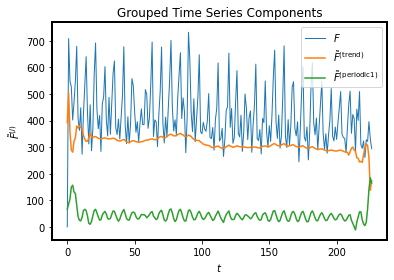

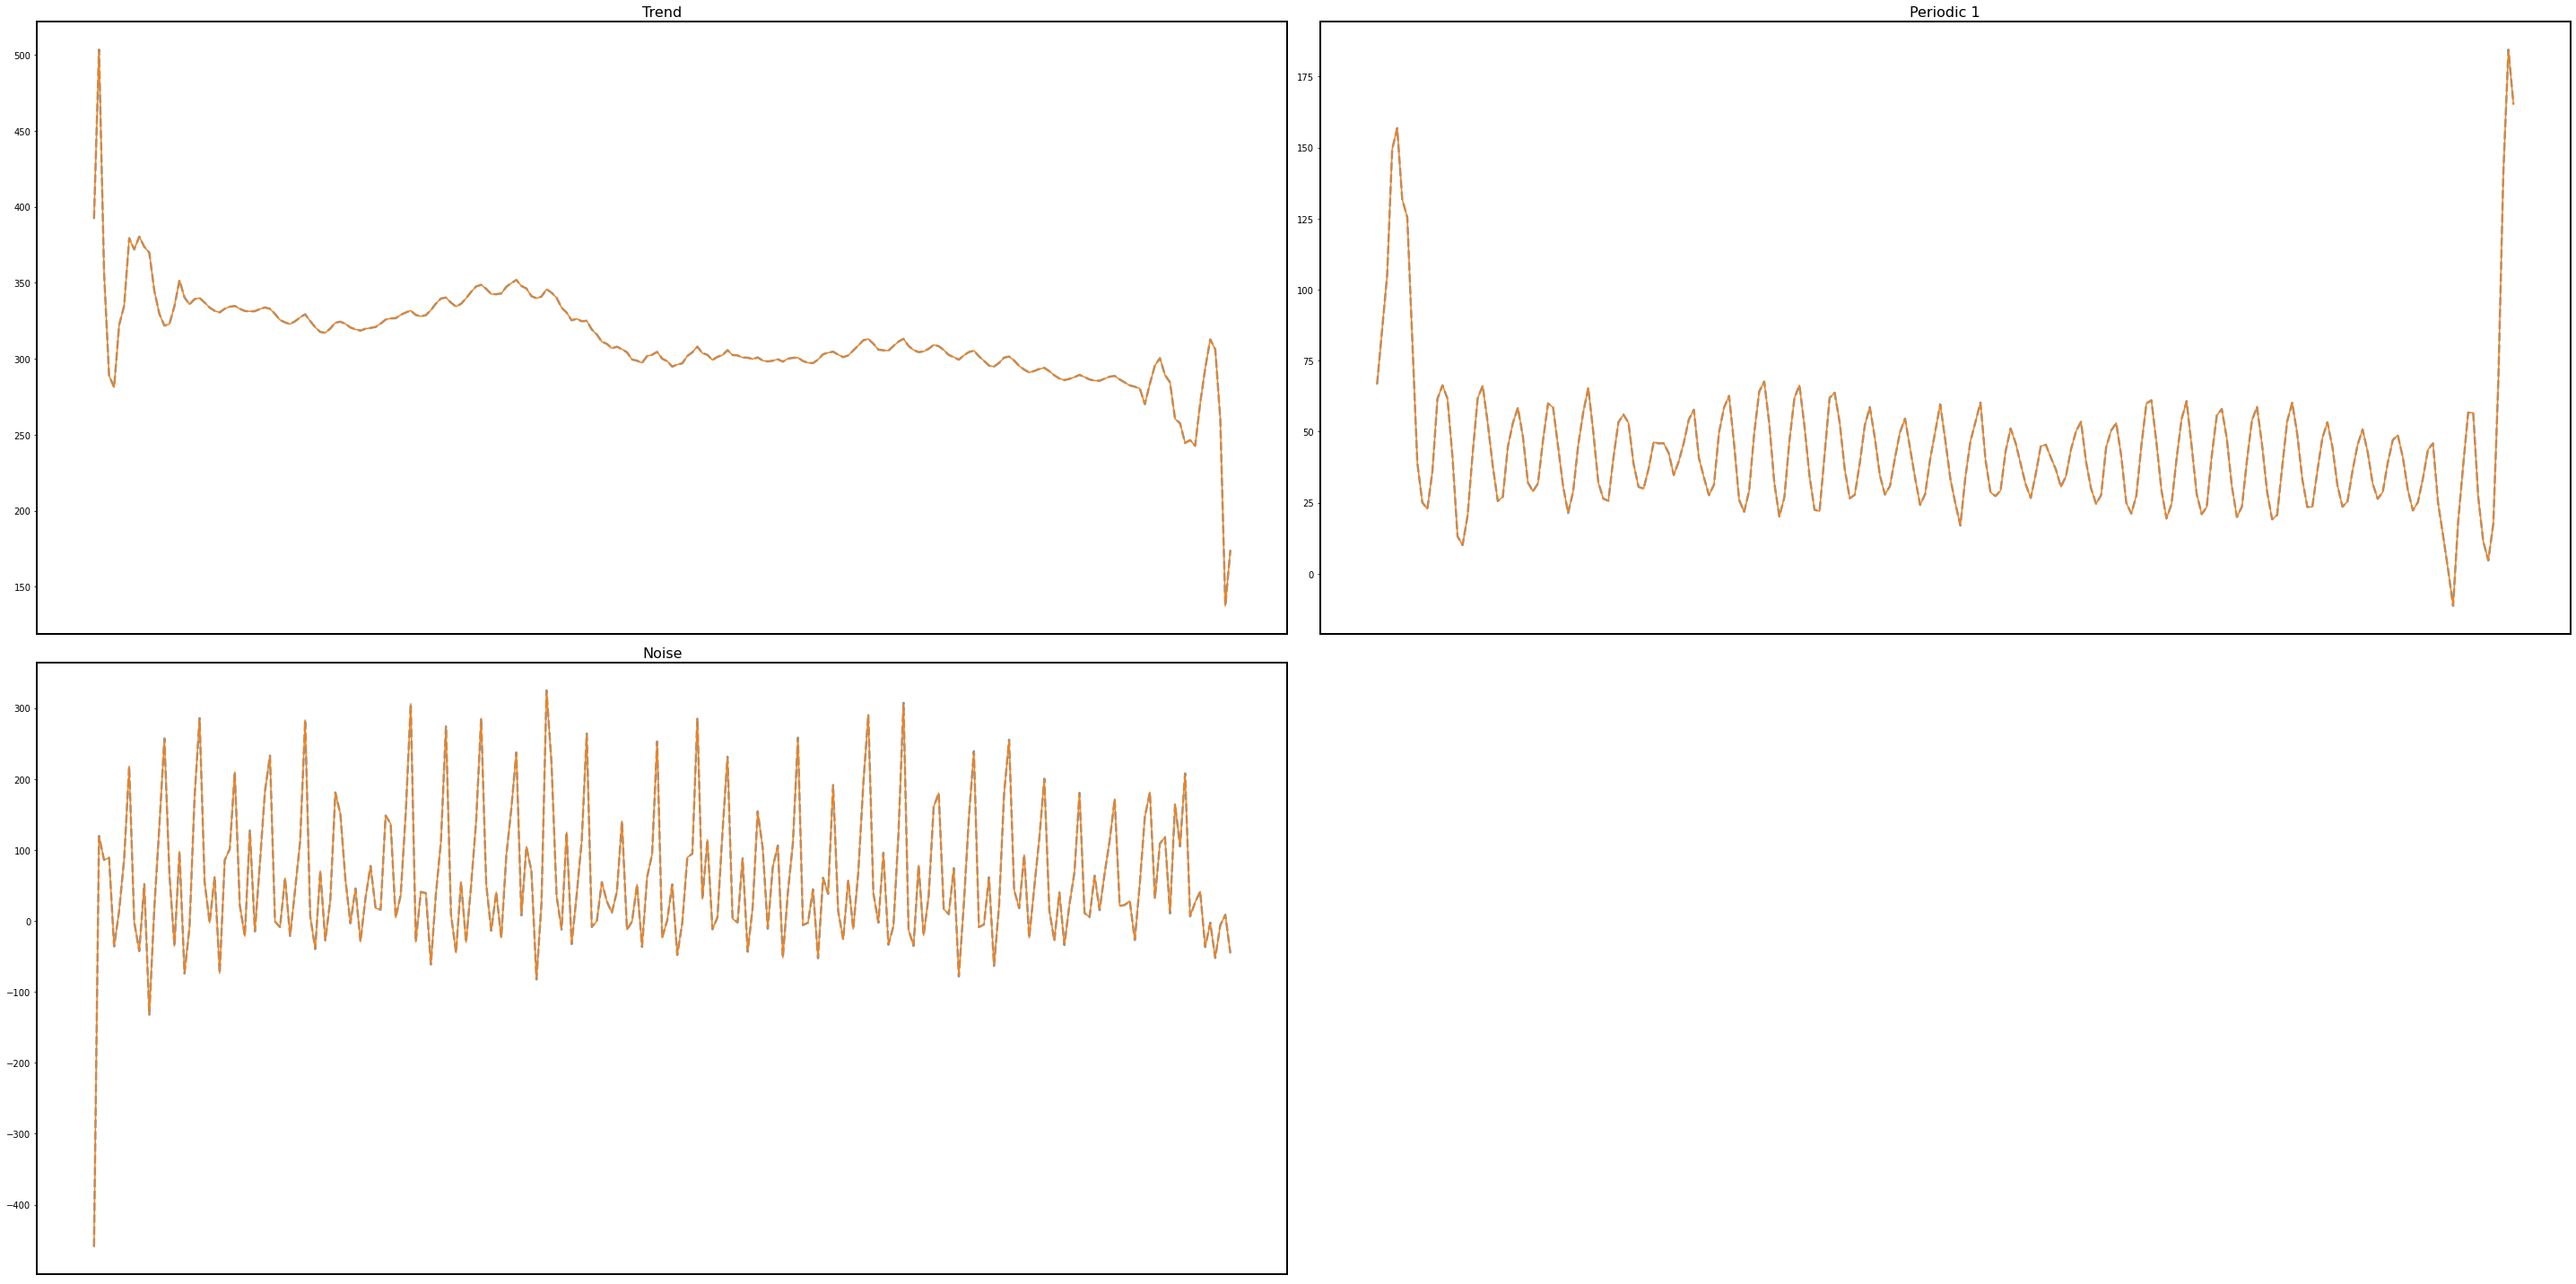

In [10]:
# Assemble the grouped components of the time series.
F_trend = X_to_TS(X_elem_pca[[0]].sum(axis=0))
F_periodic1 = X_to_TS(X_elem_pca[[1]].sum(axis=0))
# F_periodic2 = X_to_TS(X_elem_pca[[4,5]].sum(axis=0))
F_noise = X_to_TS(X_elem_pca[7:].sum(axis=0))
F_noise = F - F_trend - F_periodic1
# Plot the toy time series and its separated components on a single plot.
plt.plot(t,F, lw=1)
plt.plot(t, F_trend)
plt.plot(t, F_periodic1)
# plt.plot(t, F_periodic2)

# plt.plot(t, F_noise, alpha=0.5)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}^{(j)}$")
groups = ["trend"
          , "periodic 1"
          , "noise"
          ]
legend = ["$F$"] + [r"$\tilde{F}^{(\mathrm{%s})}$"%group for group in groups]
plt.legend(legend)
plt.title("Grouped Time Series Components")
plt.show()

# A list of tuples so we can create the next plot with a loop.
components = [("Trend", F_trend, F_trend), 
              ("Periodic 1", F_periodic1, F_periodic1),
              ("Noise", F_noise, F_noise)
              ]

# Plot the separated components and original components together.
fig = plt.figure(figsize=(40,20))
n=1
for name, orig_comp, ssa_comp in components:
    ax = fig.add_subplot(2,2,n)
    ax.plot(t, orig_comp, linestyle="--", lw=2.5, alpha=0.7)
    ax.plot(t, ssa_comp)
    ax.set_title(name, fontsize=16)
    ax.set_xticks([])
    n += 1

fig.tight_layout()